<a href="https://colab.research.google.com/github/emgeiger/PlasticScanner/blob/main/PlasticScanner_Wavelength_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf datasets
!rm -rf classes
!rm -rf resources
!git clone --depth 1 https://github.com/Plastic-Scanner/data
!mv data/data ./datasets
!rm -rf data
!git clone --depth 1 https://github.com/DataWorm/plastic-identifier.git
!mv plastic-identifier/classes ./
!mv plastic-identifier/resources ./
!rm -rf plastic-identifier

Cloning into 'data'...
remote: Enumerating objects: 1091, done.
remote: Counting objects: 100% (1091/1091), done.
remote: Compressing objects: 100% (1075/1075), done.
remote: Total 1091 (delta 16), reused 1058 (delta 14), pack-reused 0
Receiving objects: 100% (1091/1091), 38.32 MiB | 18.99 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Cloning into 'plastic-identifier'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 20 (delta 5), reused 9 (delta 2), pack-reused 0
Unpacking objects: 100% (20/20), 8.65 KiB | 1.44 MiB/s, done.


In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

from classes.SpectralDataset import SpectralDataset
from classes.DatasetLoader import DatasetLoader
from classes.AvantesDatasetLoader import AvantesDatasetLoader
from classes.SpectralonCalibrationTransformer import SpectralonCalibrationTransformer
from classes.DatasetAppenderTransformer import DatasetAppenderTransformer

In [ ]:
def extractFeatures(X : np.ndarray):
    # divides each feature by itself and all other features
    features = np.zeros(shape=(X.shape[0], X.shape[1]*X.shape[1]))
    for i in range(X.shape[1]):
        feature_column_transposed = np.reshape(X[:, i], (X.shape[0],1))
        #print(feature_column_transposed)
        with np.errstate(divide='ignore', invalid='ignore'):
            x = np.true_divide(X, feature_column_transposed)
            features[:, i*X.shape[1]:(i+1)*X.shape[1]] = np.nan_to_num(x)
    return features

def generateFeatureLabels(wavelengths : np.ndarray):
    labels = []
    for wavelength1 in wavelengths:
        for wavelength2 in wavelengths:
            labels.append('%s/%s' % (int(wavelength1), int(wavelength2)))
    return labels


<ipython-input-4-73a0fe645811>:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  materials = pd.read_csv('resources/materials.csv', index_col='label', names=['label', 'materialNumber'], squeeze=True).to_dict()


PET:
[('1686/1671', 0.025467271545217773), ('1652/1679', 0.02038557441144861), ('1682/1664', 0.018514779454244065), ('1656/1686', 0.01841926988841296), ('1686/1652', 0.017996286703075154), ('1675/1652', 0.017712659022741207), ('1694/1667', 0.017442653994188522), ('1727/1652', 0.017386515975864176), ('1660/1697', 0.0168686082140366), ('1148/1135', 0.016559161563090407)]


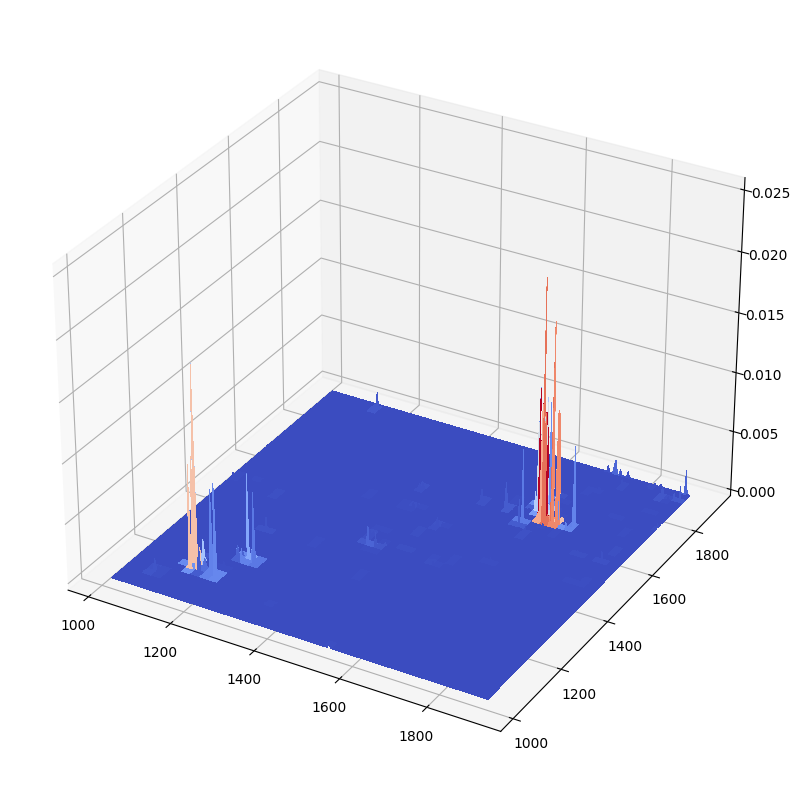

HDPE:
[('1694/1738', 0.02035590940673355), ('1701/1767', 0.019633108704561794), ('1763/1686', 0.019207543168201342), ('1213/1196', 0.019195065692086472), ('1686/1807', 0.0178287429819236), ('1209/1192', 0.010727955168115963), ('1205/1213', 0.010588400144447991), ('1705/1712', 0.010155944621585861), ('1222/1183', 0.010000000000000002), ('1771/1690', 0.010000000000000002)]


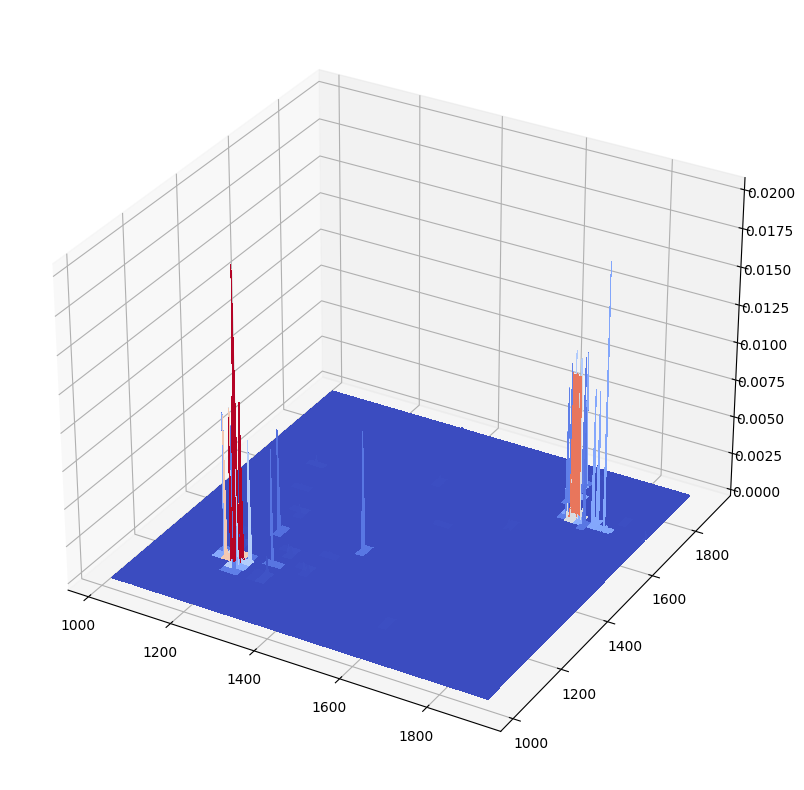

PVC:
[('1838/1835', 0.014048820681841595), ('1122/1544', 0.010526315789473684), ('1866/1412', 0.010526315789473684), ('1838/1014', 0.010526315789473684), ('1077/1209', 0.010526315789473684), ('1564/1252', 0.010526315789473684), ('1504/1108', 0.010526315789473684), ('1261/1512', 0.010526315789473684), ('1575/1122', 0.010526315789473684), ('1086/1579', 0.010526315789473684)]


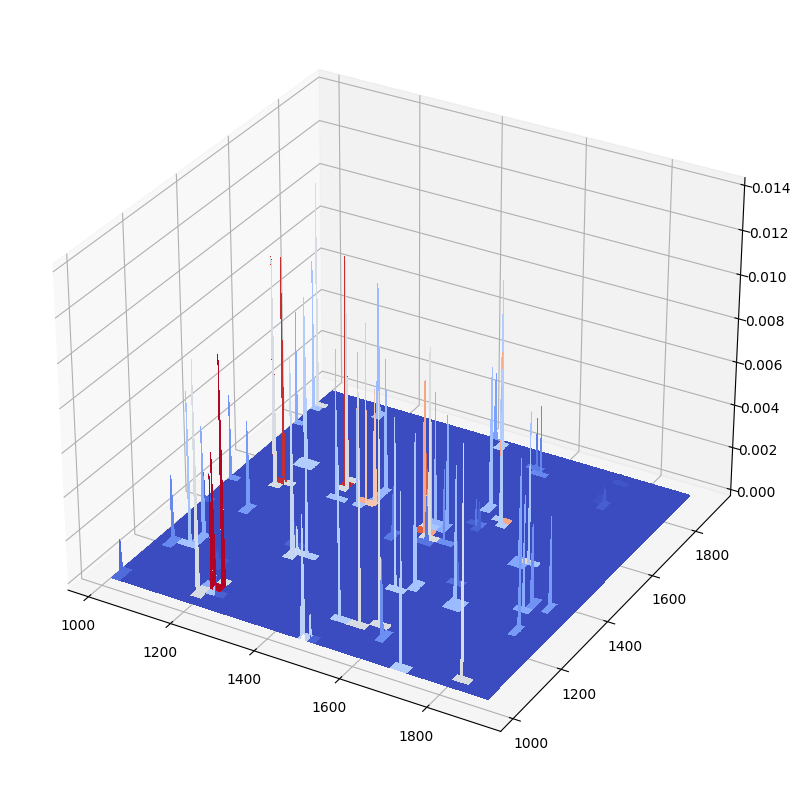

PP:
[('1679/1697', 0.021836560810443845), ('1399/1424', 0.018752324690247804), ('1686/1682', 0.01653434648593174), ('1694/1667', 0.014977776362739231), ('1686/1671', 0.014931792195343628), ('1694/1675', 0.014732448259799942), ('1412/1399', 0.014281374589149782), ('1671/1694', 0.012212051326000667), ('1667/1686', 0.011971215966718574), ('1694/1671', 0.011767832977874789)]


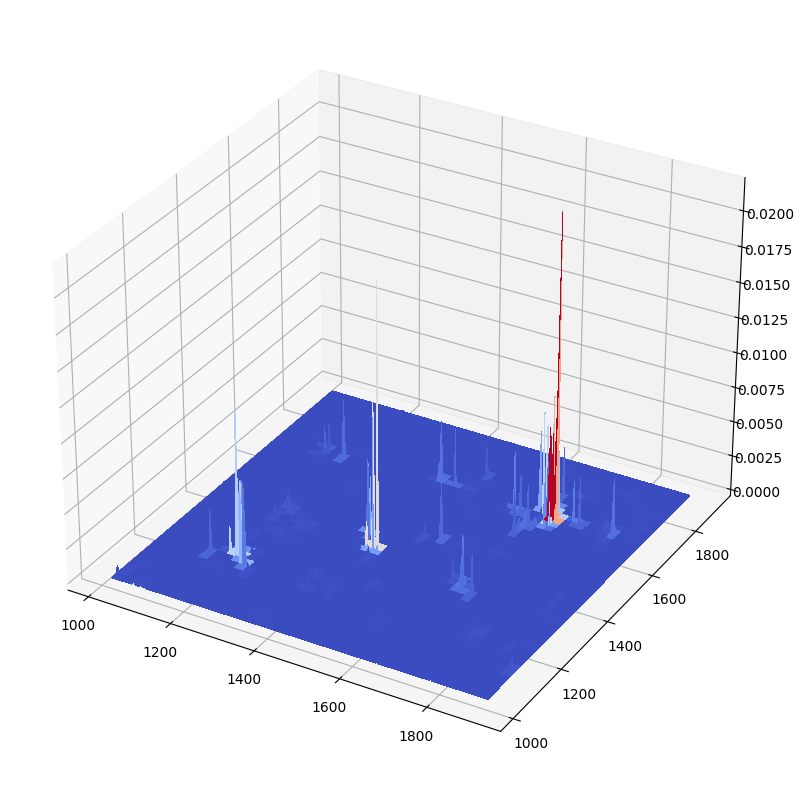

PS:
[('1192/1144', 0.015573337136627221), ('1148/1187', 0.014017958216437027), ('1144/1174', 0.012746979723750523), ('1148/1183', 0.012410921179287125), ('1152/1174', 0.010808610244282412), ('1705/1694', 0.010574406634642283), ('1166/1152', 0.009019618239559988), ('1170/1157', 0.008879189552901071), ('1144/1183', 0.00825806451612903), ('1174/1152', 0.008150871577392249)]


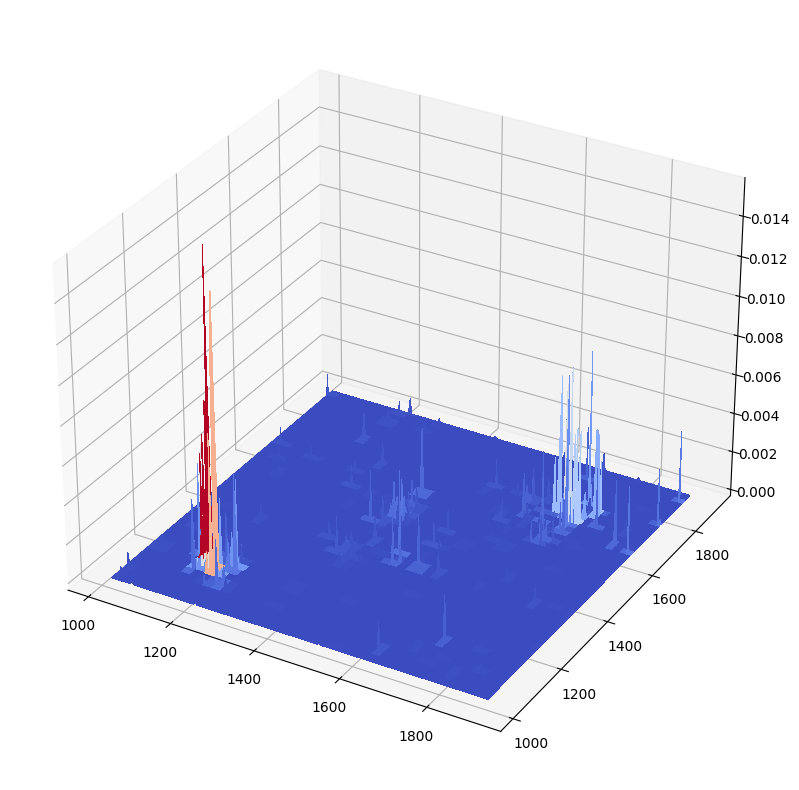

ABS:
[('1383/1599', 0.012153230174831522), ('1383/1591', 0.012057856873729934), ('1436/1464', 0.011516539901021161), ('1606/1399', 0.009318409892338902), ('1383/1568', 0.008726598496137553), ('1610/1370', 0.007455334143224827), ('1428/1464', 0.006624113964047965), ('1480/1452', 0.006576685196120567), ('1370/1618', 0.006561569906839376), ('1452/1464', 0.00639053751542846)]


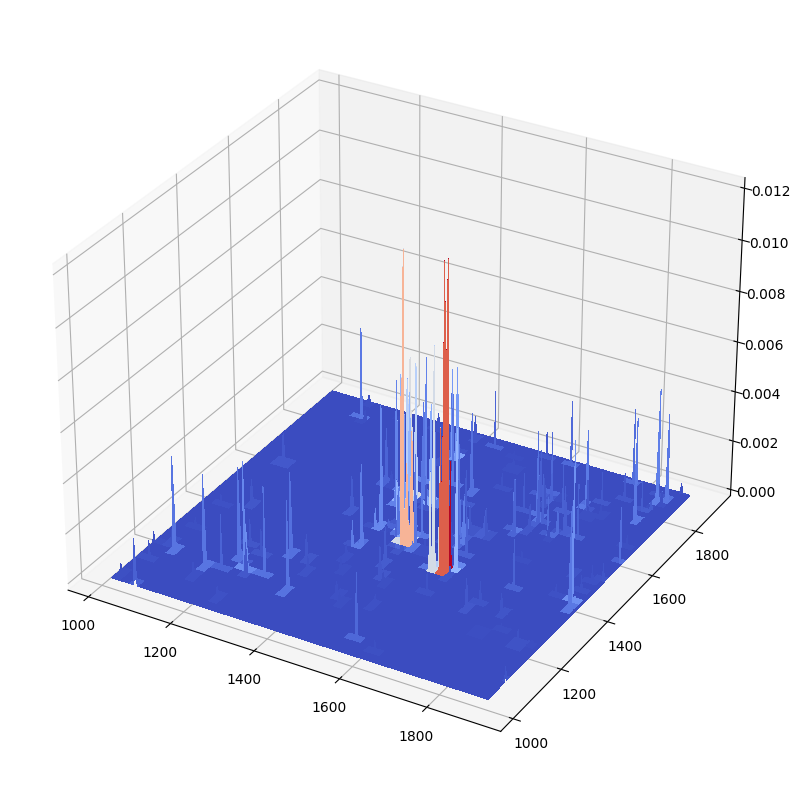

PLA:
[('1782/1880', 0.008860946745562115), ('1887/1767', 0.007768417729256441), ('1774/1884', 0.007516892292192892), ('1763/1803', 0.007480295484617375), ('1544/1432', 0.006960588115172552), ('1846/1873', 0.006926617242046642), ('1637/1564', 0.00652042426367462), ('1810/1690', 0.0064581280788177315), ('1679/1720', 0.00644767836311069), ('1023/1014', 0.006338221637517413)]


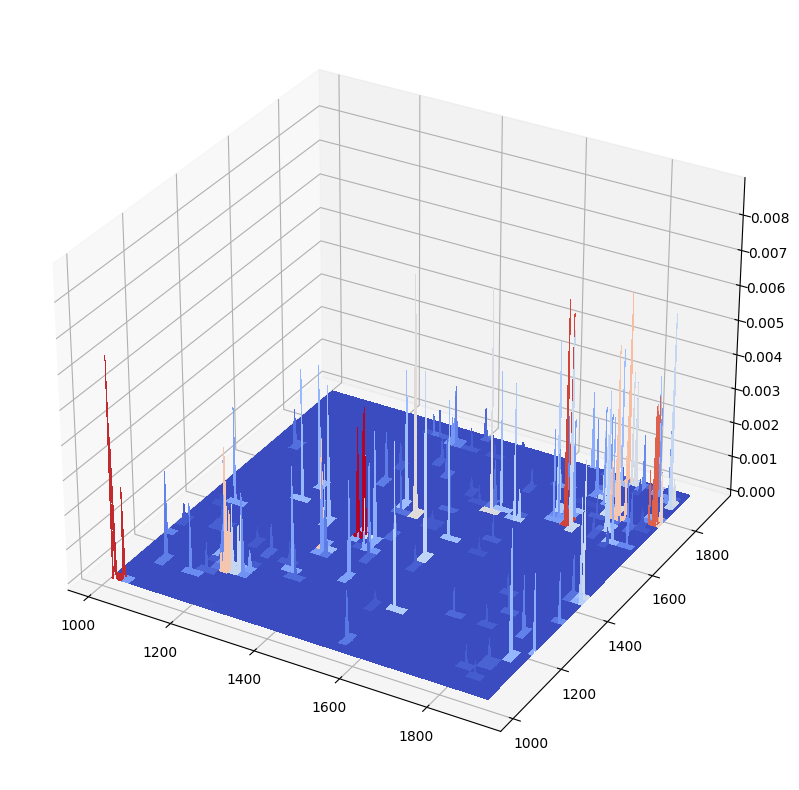

PC:
[('1618/1532', 0.015511758641483011), ('1126/1320', 0.012380238632939572), ('1130/1157', 0.01084942623682802), ('1235/1130', 0.009242335215336158), ('1516/1891', 0.00920254403131116), ('1148/1135', 0.009112570497411234), ('1778/1656', 0.008926747123210788), ('1152/1144', 0.008504846706539941), ('1157/1183', 0.00849465602890261), ('1299/1720', 0.008364130434782591)]


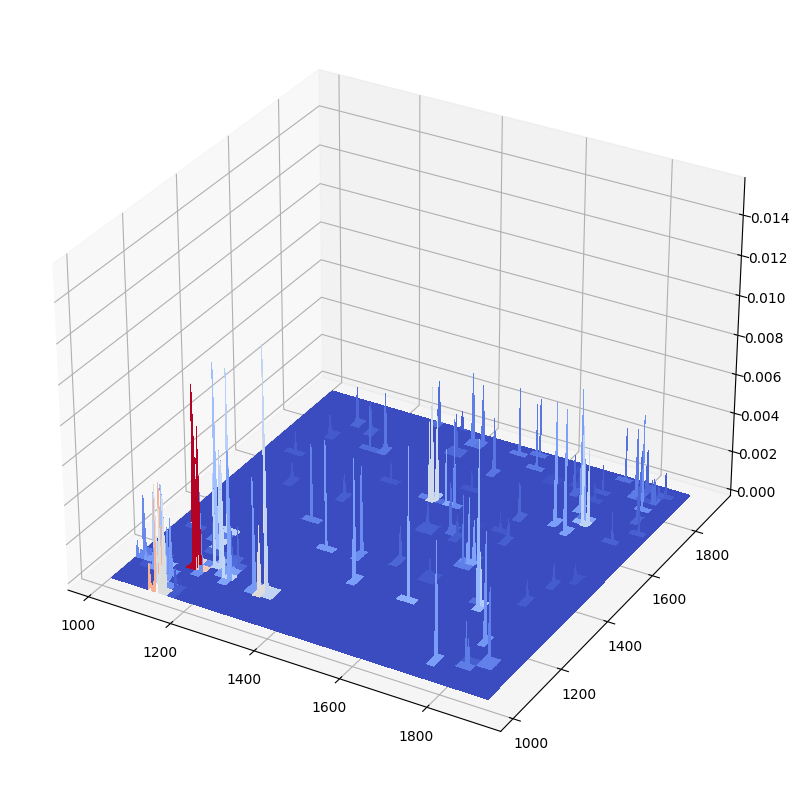

PMMA:
[('1366/1504', 0.019999999999999997), ('1835/1785', 0.019999999999999997), ('1785/1799', 0.019999999999999997), ('1161/1192', 0.009999999999999998), ('1117/1166', 0.009999999999999998), ('1157/1122', 0.009999999999999998), ('1476/1374', 0.009999999999999998), ('1341/1307', 0.009999999999999998), ('1341/1324', 0.009999999999999998), ('1286/1345', 0.009999999999999998)]


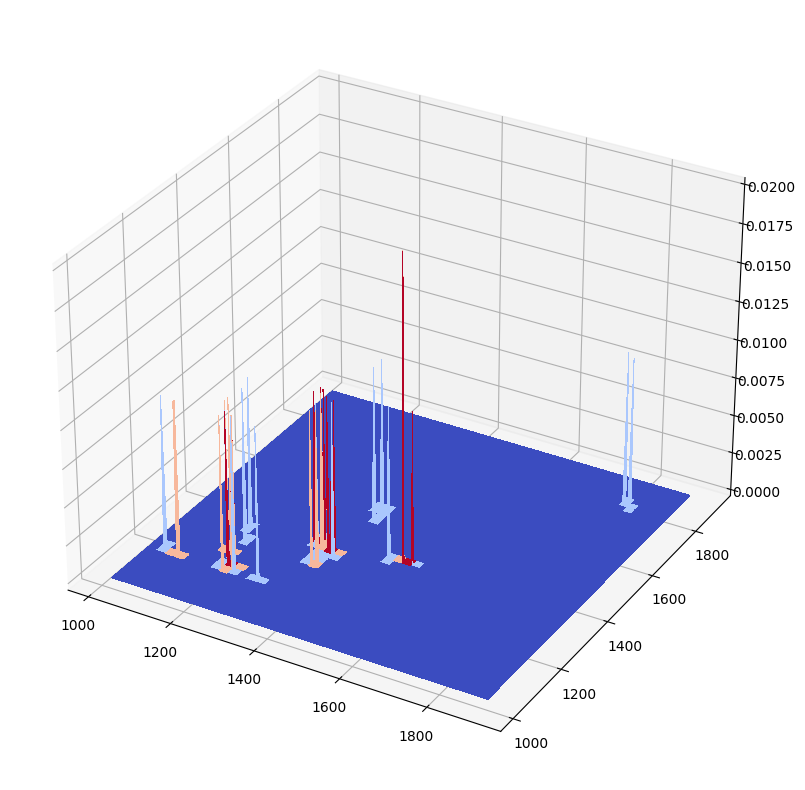

ASA:
[('1870/1838', 0.015554907396377647), ('1745/1734', 0.010179712012550432), ('1073/1544', 0.010104861188928727), ('1679/1648', 0.010094654258434867), ('1337/1528', 0.010089194737473044), ('1436/1579', 0.010064556899286278), ('1139/1690', 0.01005024031763724), ('1671/1231', 0.010006619482925264), ('1261/1126', 0.009985099871134022), ('1218/1023', 0.009960506029086899)]


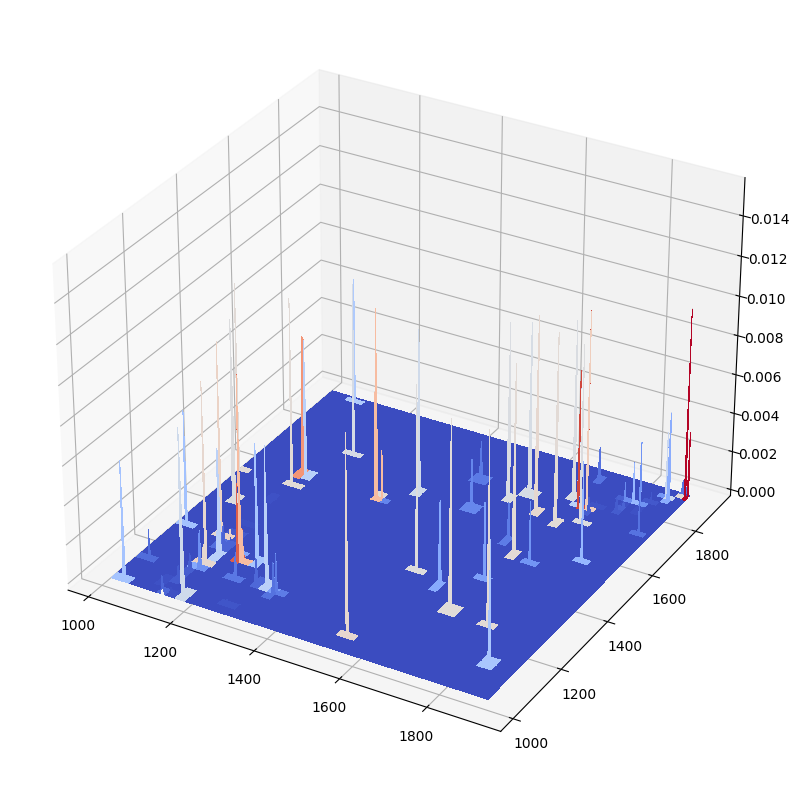

PACF:
[('1540/1682', 0.02127659574468085), ('1496/1664', 0.017784032359088833), ('1686/1552', 0.016810875799473747), ('1633/1686', 0.011169137010654301), ('1648/1500', 0.010638297872340425), ('1591/1760', 0.010638297872340425), ('1583/1679', 0.010638297872340425), ('1583/1682', 0.010638297872340425), ('1552/1831', 0.010638297872340425), ('1667/1552', 0.010638297872340425)]


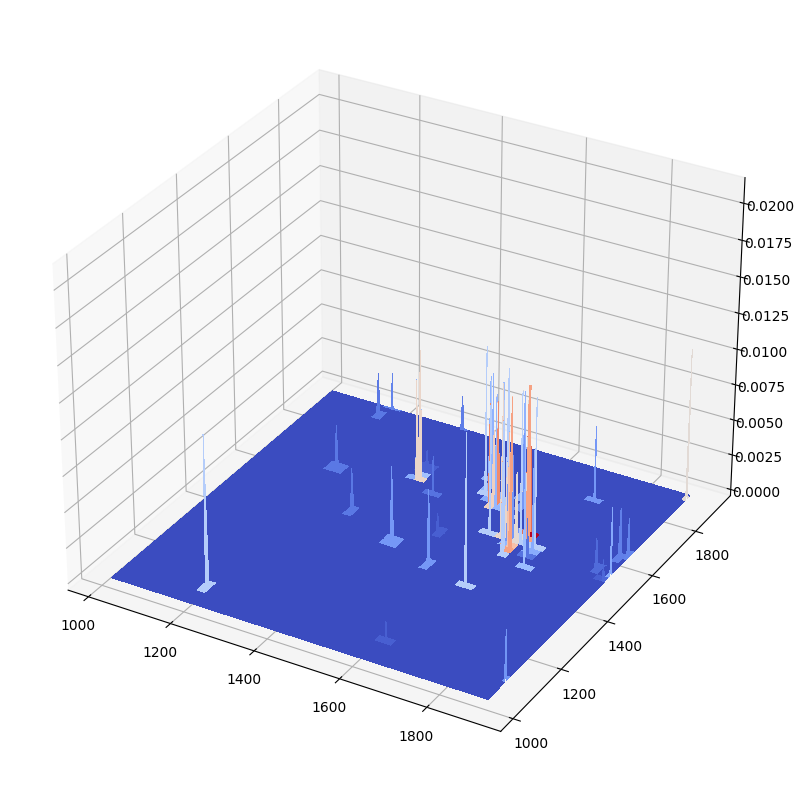

PCCF:
[('1894/1897', 0.016494247939560443), ('1626/1599', 0.015223996488716947), ('1656/1564', 0.012809484285293549), ('1690/1564', 0.01098901098901099), ('1697/1568', 0.01098901098901099), ('1488/1671', 0.01098901098901099), ('1656/1299', 0.01098901098901099), ('1095/1099', 0.01098901098901099), ('1560/1660', 0.01098901098901099), ('1901/1552', 0.01098901098901099)]


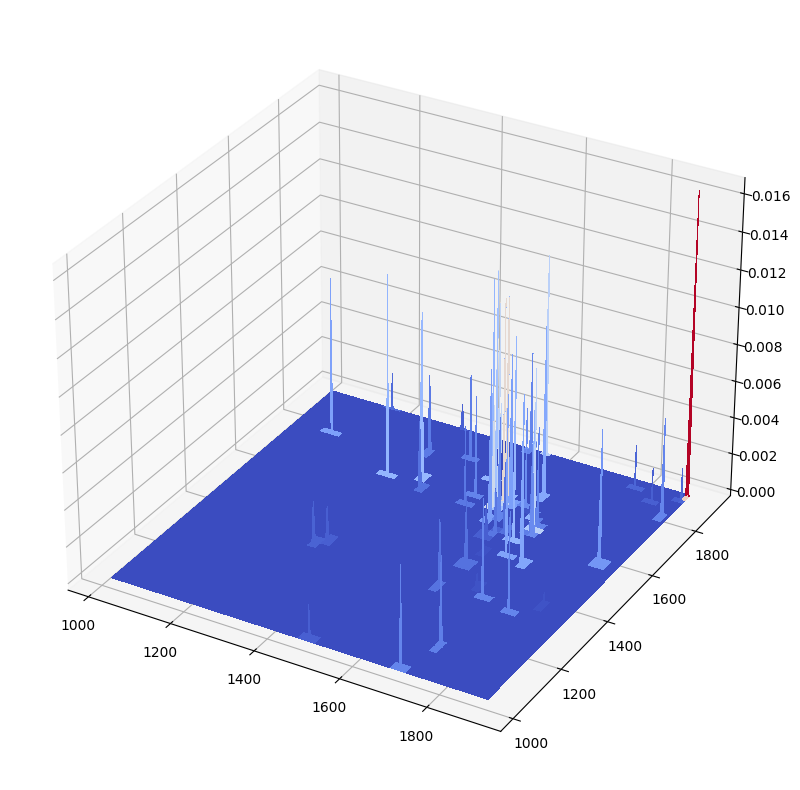

PETG:
[('1504/1500', 0.010416666666666666), ('1690/1731', 0.01018581467456224), ('1697/1897', 0.010138811383928576), ('1023/1032', 0.010100333921370965), ('1540/1626', 0.010077165984700244), ('1771/1682', 0.010074943438914045), ('1095/1041', 0.009983228600543485), ('1723/1686', 0.009980080768391195), ('1742/1690', 0.009947317550474923), ('1712/1679', 0.009914641596524588)]


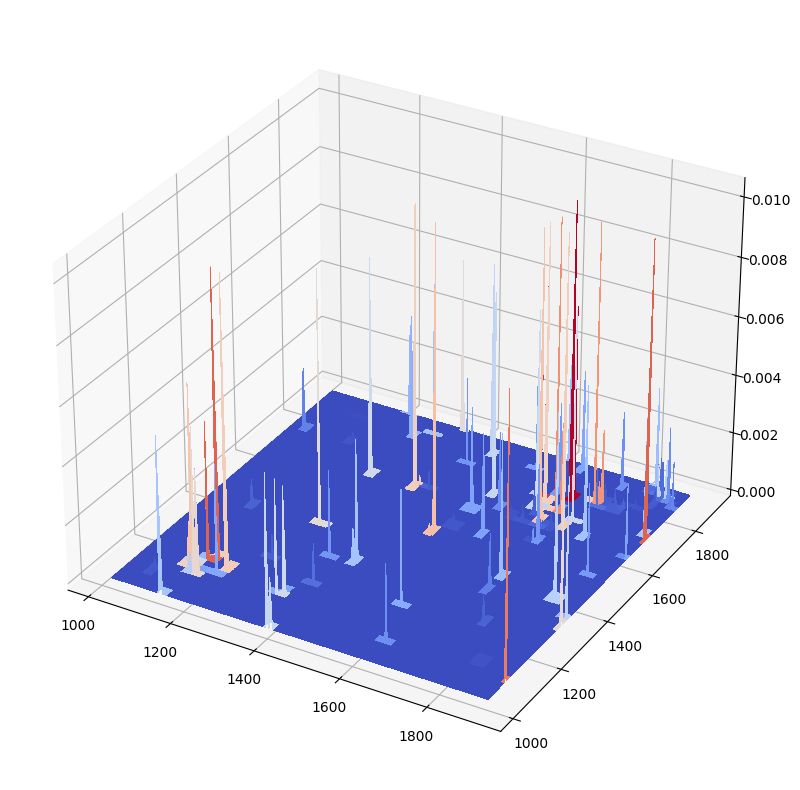

In [ ]:
# Load list of materials to be considered for training and map them to numbers
materials = pd.read_csv('resources/materials.csv', index_col='label', names=['label', 'materialNumber'], squeeze=True).to_dict()
number_material_map = {v: k for k, v in materials.items()}

# Define which datasets shall be loaded for train and test data (if same dataset is used for train and test, data will be splitted)
#ds_train = AvantesDatasetLoader('datasets/20221003_avantes_spectrometer/data', materials).load()
ds_train = AvantesDatasetLoader('datasets/20230419_avantes_spectrometer_fifth_dataset', materials).load()
wavelengths = ds_train.wavelengths

# Extract features from measurements
X = extractFeatures(ds_train.X)
y = ds_train.y
feature_labels = generateFeatureLabels(wavelengths)

for materialLabel, materialNumber in materials.items():
    if not np.any(y == materialNumber):
        continue
    if materialLabel in ['Spectralon', 'spectralon']:
        continue

    # compare current material against all others (OneVsAll)
    y_one_vs_all = np.where(y == materialNumber, 1, 0)
    clf = RandomForestClassifier(random_state=1)
    clf.fit(X, y_one_vs_all)

    # Index sort the most important features
    sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1] # Reverse sort
    # Get the most important features names and weights
    most_important_features = np.take_along_axis(
        np.array(feature_labels),
        sorted_feature_weight_idxes, axis=0)
    most_important_weights = np.take_along_axis(
        np.array(clf.feature_importances_),
        sorted_feature_weight_idxes, axis=0)

    # Show
    print(materialLabel + ':')
    print(list(zip(most_important_features, most_important_weights))[:10])

    weights = clf.feature_importances_
    plot_x, plot_y = np.meshgrid(wavelengths, wavelengths)
    plot_z = np.reshape(weights, (wavelengths.shape[0],wavelengths.shape[0]))
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    fig.set_size_inches(10, 10)
    surf = ax.plot_surface(plot_x, plot_y, plot_z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    plt.show()
